In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys

PROJECT_ROOT = "/mnt/hdd/ttoxopeus/basic_UNet"

if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)
    print(f"✅ Added project root to sys.path:\n   {PROJECT_ROOT}")
else:
    print(f"ℹ️ Project root already in sys.path:\n   {PROJECT_ROOT}")

from src.utils.reproducibility import seed_everything
from src.training.data_loader import SegmentationDataset  # adjust if your path differs

plt.rcParams["figure.figsize"] = (11, 8)


✅ Added project root to sys.path:
   /mnt/hdd/ttoxopeus/basic_UNet


/media/ttoxopeus/miniconda3/envs/nnunet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def overlay_label_edges(ax, img2d, lbl2d, title=""):
    ax.imshow(img2d, cmap="gray")

    edges = np.zeros_like(lbl2d, dtype=bool)
    edges[:-1, :] |= (lbl2d[:-1, :] != lbl2d[1:, :])
    edges[:, :-1] |= (lbl2d[:, :-1] != lbl2d[:, 1:])

    # show edges only (masked array avoids coloring the background)
    edge_vis = np.ma.masked_where(~edges, edges.astype(np.float32))
    ax.imshow(edge_vis, cmap="autumn", alpha=0.9)

    ax.set_title(title)
    ax.axis("off")



IMG_DIR = "/media/ttoxopeus/datasets/nnUNet_raw/Dataset200_ACDC/imagesTr"
LBL_DIR = "/media/ttoxopeus/datasets/nnUNet_raw/Dataset200_ACDC/labelsTr"

# dataset settings (match your training)
TARGET_SIZE = (256, 256)
NUM_SLICES_PER_VOLUME = 30
SLICE_AXIS = 2

SEED = 42
N_EXAMPLES = 1


In [3]:
img_paths = sorted([os.path.join(IMG_DIR, f) for f in os.listdir(IMG_DIR) if f.endswith(".nii.gz")])
lbl_paths = sorted([os.path.join(LBL_DIR, f) for f in os.listdir(LBL_DIR) if f.endswith(".nii.gz")])

assert len(img_paths) == len(lbl_paths), "Number of images and labels must match!"
pairs = list(zip(img_paths, lbl_paths))

print("Num volumes:", len(pairs))
print("First pair:", pairs[0])

seed_everything(SEED, deterministic=False)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

ds_clean = SegmentationDataset(
    pairs,
    slice_axis=SLICE_AXIS,
    normalize=True,
    target_size=TARGET_SIZE,
    augment=False,
    num_slices_per_volume=NUM_SLICES_PER_VOLUME,
    use_cache=False,
)

ds_aug = SegmentationDataset(
    pairs,
    slice_axis=SLICE_AXIS,
    normalize=True,
    target_size=TARGET_SIZE,
    augment=True,
    num_slices_per_volume=NUM_SLICES_PER_VOLUME,
    use_cache=False,
)

print("Num slice samples:", len(ds_clean))


Num volumes: 200
First pair: ('/media/ttoxopeus/datasets/nnUNet_raw/Dataset200_ACDC/imagesTr/patient001_ED_0000.nii.gz', '/media/ttoxopeus/datasets/nnUNet_raw/Dataset200_ACDC/labelsTr/patient001_ED.nii.gz')
Num slice samples: 1902


/mnt/hdd/ttoxopeus/basic_UNet/src/training/data_loader.py:276: UserWarning: Argument(s) 'value, mask_value' are not valid for transform ElasticTransform
  A.ElasticTransform(
/mnt/hdd/ttoxopeus/basic_UNet/src/training/data_loader.py:284: UserWarning: Argument(s) 'value, mask_value' are not valid for transform GridDistortion
  A.GridDistortion(


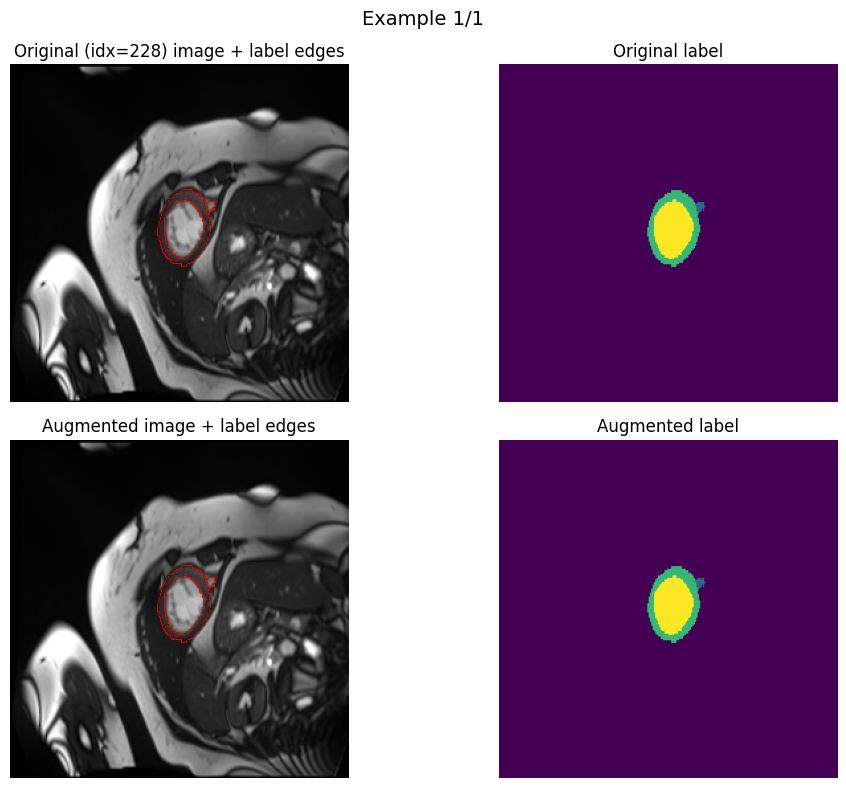

In [5]:
idxs = random.sample(range(len(ds_clean)), k=min(N_EXAMPLES, len(ds_clean)))

for i, idx in enumerate(idxs, start=1):
    img0, lbl0 = ds_clean[idx]
    img1, lbl1 = ds_aug[idx]

    img0 = img0.squeeze(0).numpy()
    img1 = img1.squeeze(0).numpy()
    lbl0 = lbl0.numpy()
    lbl1 = lbl1.numpy()

    fig, axes = plt.subplots(2, 2)

    overlay_label_edges(axes[0, 0], img0, lbl0, f"Original (idx={idx}) image + label edges")
    axes[0, 1].imshow(lbl0, cmap="viridis")
    axes[0, 1].set_title("Original label")
    axes[0, 1].axis("off")

    overlay_label_edges(axes[1, 0], img1, lbl1, "Augmented image + label edges")
    axes[1, 1].imshow(lbl1, cmap="viridis")
    axes[1, 1].set_title("Augmented label")
    axes[1, 1].axis("off")

    fig.suptitle(f"Example {i}/{len(idxs)}", fontsize=14)
    plt.tight_layout()
    plt.show()


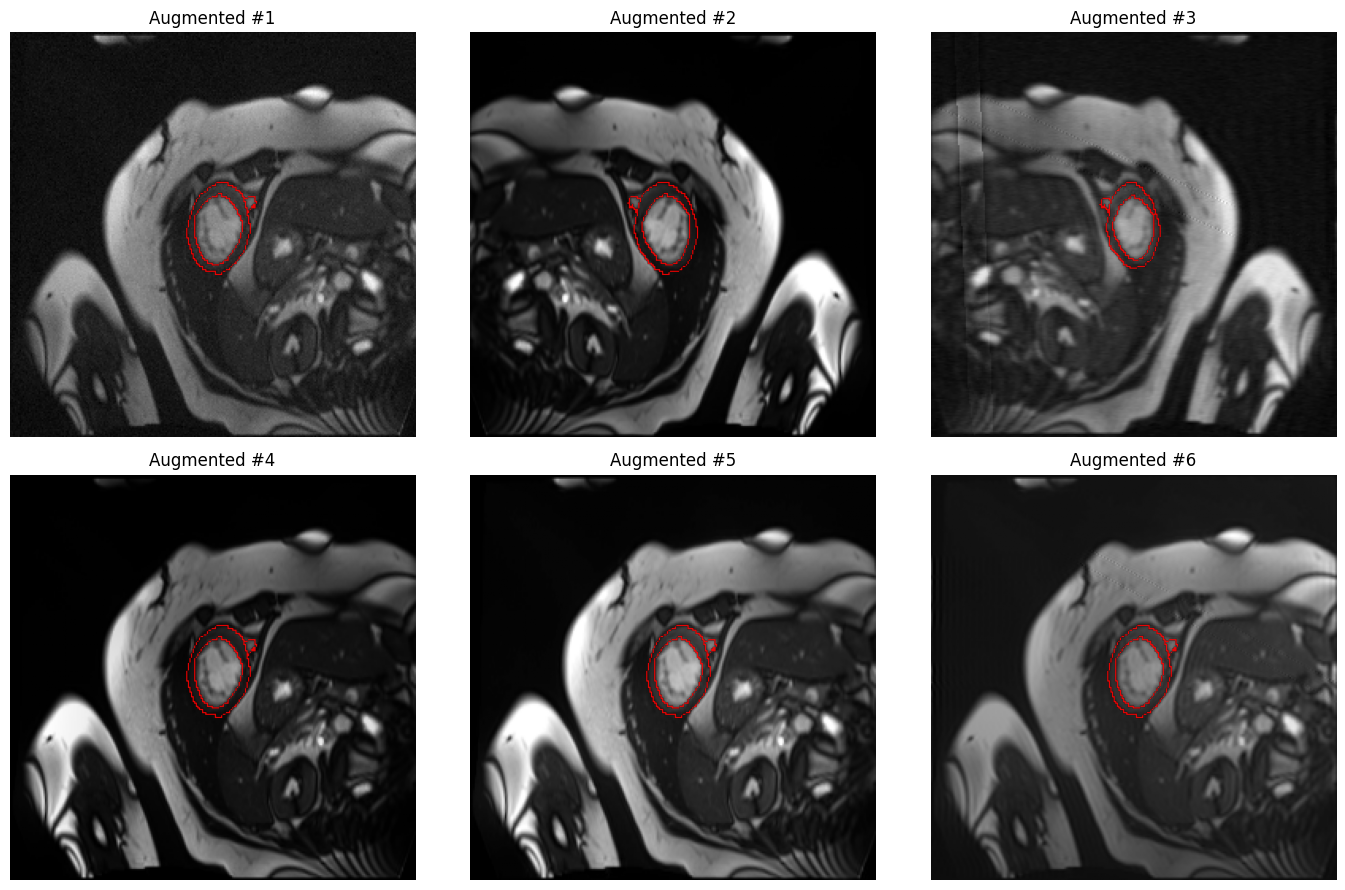

In [8]:
IDX = idxs[0]  # pick one from above
K = 6          # how many different augmentations

img0, lbl0 = ds_clean[IDX]
img0 = img0.squeeze(0).numpy()
lbl0 = lbl0.numpy()

fig, axes = plt.subplots(2, 3, figsize=(14, 9))
axes = axes.flatten()

for k in range(K):
    img1, lbl1 = ds_aug[IDX]
    img1 = img1.squeeze(0).numpy()
    lbl1 = lbl1.numpy()
    overlay_label_edges(axes[k], img1, lbl1, f"Augmented #{k+1}")

plt.tight_layout()
plt.show()
